In [20]:
import pandas as pd
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# 1. Load dataset
df = pd.read_csv('ulasan_gojek.csv')  

# 2. Label sentimen berdasarkan rating
def get_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['rating'].apply(get_sentiment)

# 3. Ambil subset dari masing-masing kelas 
sample_size_per_class = 25  # total sekitar 75 baris

balanced_df = df.groupby('sentiment').apply(
    lambda x: x.sample(n=min(sample_size_per_class, len(x)), random_state=42)
).reset_index(drop=True)

# 4. Preprocessing dengan Sastrawi
stop_factory = StopWordRemoverFactory()
stopword = stop_factory.create_stop_word_remover()

stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

def preprocess(text):
    text = stopword.remove(text.lower())
    text = stemmer.stem(text)
    return text

balanced_df['clean_ulasan'] = balanced_df['ulasan'].astype(str).apply(preprocess)

# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(
    balanced_df['clean_ulasan'], balanced_df['sentiment'], test_size=0.2, random_state=42
)

# 6. Pipeline vectorizer + classifier
model = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB(alpha=0.5))
])

# 7. Train
model.fit(X_train, y_train)

# 8. Prediksi pada 5 data random
random_data = balanced_df.sample(5, random_state=42).copy()
random_data['predicted_sentiment'] = model.predict(random_data['clean_ulasan'])

# 9. Tampilkan hasil
print(random_data[['ulasan', 'rating', 'sentiment', 'predicted_sentiment']])


C:\Users\amatr\AppData\Local\Temp\ipykernel_15740\2750617233.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('sentiment').apply(


                                               ulasan  rating sentiment  \
4   gini amat dah gojek gada voucer apa apa mentok...       2  negative   
63  Kak mau tanyasaya ngga buka apk tpi kok tiba2 ...       4  positive   
10  Gojek makin ke sini makin gila aja ni ngasih d...       1  negative   
0   Tadi nya gojek bagus sih lancar  Tp skrg serin...       2  negative   
35  Kenapa nih belakangan sering hang aplikasinya ...       3   neutral   

   predicted_sentiment  
4             negative  
63             neutral  
10            negative  
0              neutral  
35             neutral  


In [21]:
from sklearn.metrics import confusion_matrix


y_pred = model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[3 1 2]
 [3 2 0]
 [0 1 3]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.50      0.50      0.50         6
     neutral       0.50      0.40      0.44         5
    positive       0.60      0.75      0.67         4

    accuracy                           0.53        15
   macro avg       0.53      0.55      0.54        15
weighted avg       0.53      0.53      0.53        15



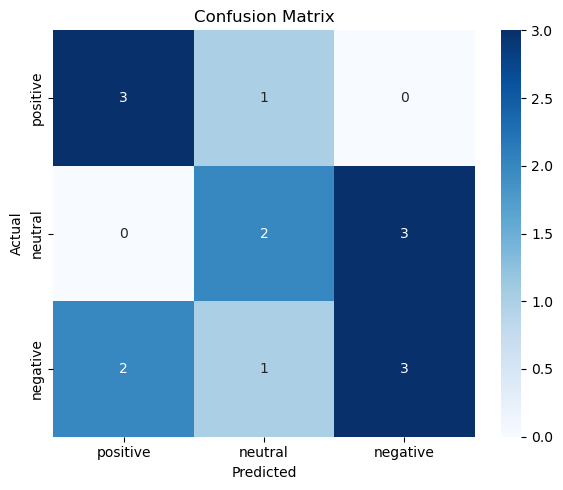

C:\Users\amatr\AppData\Local\Temp\ipykernel_15740\1772144157.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


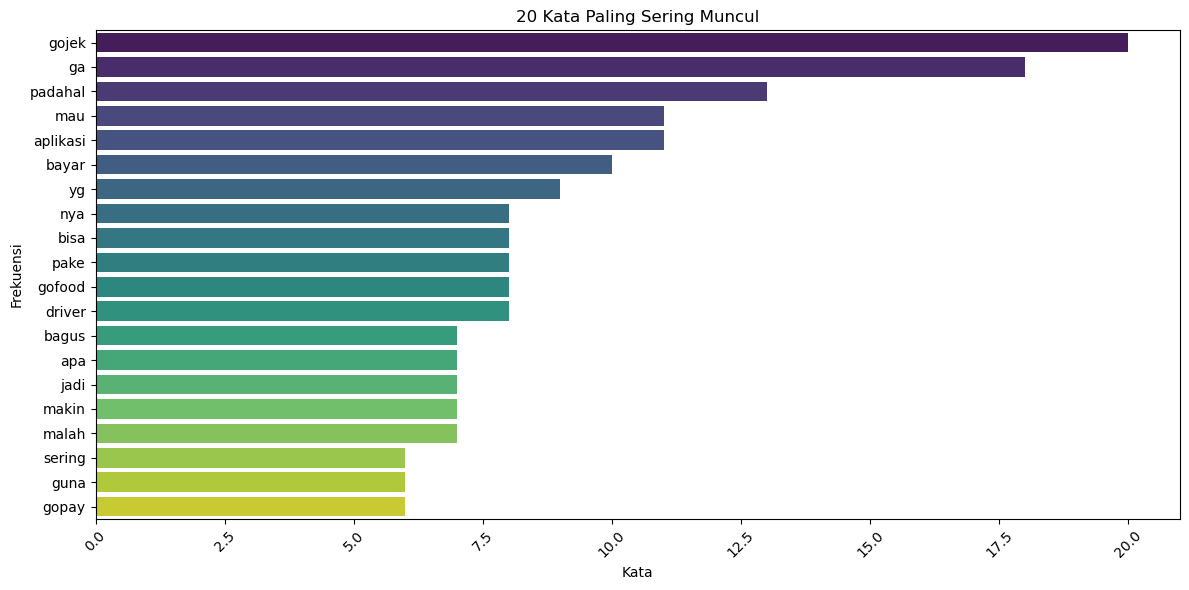

In [ ]:
# 🔍 Confusion Matrix & Classification Report
from typing import Counter
from matplotlib import pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'neutral', 'negative'])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 📈 Visualisasi Distribusi Frekuensi Kata
all_words = ' '.join(balanced_df['clean_ulasan']).split()
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)

words, counts = zip(*most_common_words)

plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('20 Kata Paling Sering Muncul')
plt.xticks(rotation=45)
plt.ylabel('Frekuensi')
plt.xlabel('Kata')
plt.tight_layout()
plt.show()